In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Documents/programming/BME-574-2024`


In [2]:
Pkg.add(["Plots","Distributions","Random","ForwardDiff"])

    Updating registry at `~/.julia/registries/JuliaComputingRegistry.toml`
    Updating registry at `~/.julia/registries/JuliaHubRegistry.toml`
   Resolving package versions...
  No Changes to `~/Documents/programming/BME-574-2024/Project.toml`
  No Changes to `~/Documents/programming/BME-574-2024/Manifest.toml`


In [3]:
using Plots, Distributions, Random, ForwardDiff

A good measure for the floating point machine precision is the largest number that added to 1 results in 1.  This number is called $\epsilon$. $1 + \epsilon = 1$

In [4]:
eps(1.0)

2.220446049250313e-16

We now would like to calculate the error of estimating the derivative by the finite difference method.
In our example we calculate $\frac{d}{dx}exp(x)$ at $x=1.0$ using the estimate

$$\frac{exp(1.0+\Delta x)-exp(1.0)}{\Delta x}$$

In [5]:
dx = 10.0 .^ collect(-19:0.2:-1)
dy = abs.((exp.(1.0 .+ dx) .- exp(1.0)) ./ dx .- exp(1.0))

91-element Vector{Float64}:
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 2.718281828459045
 ⋮
 0.0008577403322913568
 0.0013595940741804036
 0.002155231636380428
 0.003416867950315705
 0.0054180249002331315
 0.008593664031034454
 0.013636827328078915
 0.021655184415799056
 0.034427733657234505
 0.05483360904826595
 0.08758841956955754
 0.14056012641483795

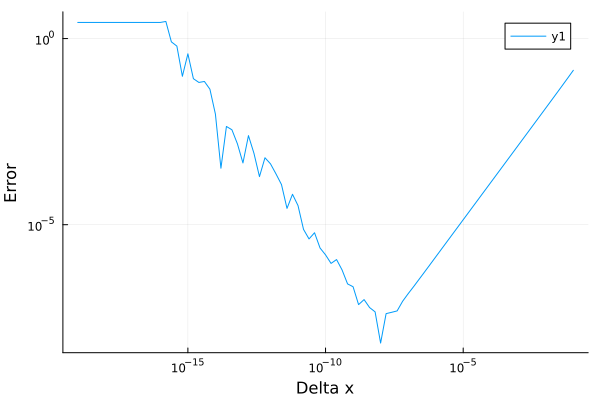

In [6]:
plot(dx,dy,yscale=:log10,xscale=:log10,xlabel="Delta x",ylabel="Error")

The problem with finite differencing is that we are mixing our really small
number with the really large number, and so when we do the subtract we lose
accuracy. Instead, we want to keep the small perturbation completely separate.

To see how to do this, assume that $x \in \mathbb{R}$ and assume that $f$ is
complex analytic. You want to calculate a real derivative, but your function
just happens to also be complex analytic when extended to the complex plane.
Thus it has a Taylor series, and let's see what happens when we expand out this
Taylor series purely in the complex direction:

$$f(x+ih) = f(x) + f'(x)ih + \mathcal{O}(h^2)$$

which we can re-arrange as:

$$if'(x) = \frac{f(x+ih) - f(x)}{h} + \mathcal{O}(h)$$

Since $x$ is real and $f$ is real-valued on the reals, $if'$ is purely imaginary.
So let's take the imaginary parts of both sides:

$$f'(x) = \frac{Im(f(x+ih))}{h} + \mathcal{O}(h)$$

since $Im(f(x)) = 0$ (since it's real valued!). Thus with a sufficiently small
choice of $h$, this is the *complex step differentiation* formula for calculating
the derivative.

But to understand the computational advantage, recal that $x$ is pure real, and
thus $x+ih$ is an imaginary number where **the $h$ never directly interacts with
$x$** since a complex number is a two dimensional number where you keep the two
pieces separate. Thus there is no numerical cancellation by using a small value
of $h$, and thus, due to the relative precision of floating point numbers, both
the real and imaginary parts will be computed to (approximately) 16 digits of
accuracy for any choice of $h$.

## A different way of looking at derivatives

The derivative measures the **sensitivity** of a function, i.e. how much the
function output changes when the input changes by a small amount $\epsilon$:

$$f(a + \epsilon) = f(a) + f'(a) \epsilon + o(\epsilon).$$

In the following we will ignore higher-order terms; formally we set
$\epsilon^2 = 0$, which results in a nilpotent algebra.

A function $f$ will be represented by its value $f(a)$ and derivative $f'(a)$,
encoded as the coefficients of a degree-1 (Taylor) polynomial in $\epsilon$:

$$f \rightsquigarrow f(a) + \epsilon f'(a)$$

Conversely, if we have such an expansion in $\epsilon$ for a given function $f$,
then we can identify the coefficient of $\epsilon$ as the derivative of $f$.

## Dual numbers

Thus, to extend the idea of complex step differentiation beyond complex analytic
functions, we define a new number type, the *dual number*. A dual number is a
multidimensional number where the sensitivity of the function is propagated
along the dual portion.

Here we will now start to use $\epsilon$ as a dimensional signifier, like $i$,
$j$, or $k$ for quaternion numbers. In order for this to work out, we need
to derive an appropriate algebra for our numbers. To do this, we will look
at Taylor series to make our algebra reconstruct differentiation.

Note that the chain rule has been explicitly encoded in the derivative part.

$$f(a + \epsilon) = f(a) + \epsilon f'(a)$$

to first order. If we have two functions

$$f \rightsquigarrow f(a) + \epsilon f'(a)$$
$$g \rightsquigarrow g(a) + \epsilon g'(a)$$

then we can manipulate these Taylor expansions to calculate combinations of
these functions as follows. Using the nilpotent algebra, we have that:

$$(f + g) = [f(a) + g(a)] + \epsilon[f'(a) + g'(a)]$$

$$(f \cdot g) = [f(a) \cdot g(a)] + \epsilon[f(a) \cdot g'(a) + g(a) \cdot f'(a) ]$$

From these we can *infer* the derivatives by taking the component of $\epsilon$.
These also tell us the way to implement these in the computer.

In [7]:
struct MyDual
    val::Float64
    partial::Float64
end

In [8]:
val(x::MyDual) = x.val
partial(x::MyDual) = x.partial

partial (generic function with 1 method)

In [9]:
a = MyDual(2,1)

MyDual(2.0, 1.0)

In [10]:
val(a)

2.0

In [11]:
partial(a)

1.0

In [17]:
Base.:+(f::MyDual, g::MyDual) = MyDual(f.val + g.val, f.partial + g.partial)
Base.:+(f::MyDual, α::Number) = MyDual(f.val + α, f.partial)
Base.:+(α::Number, f::MyDual) = f + α

#=
You can also write:
import Base: +
f::MyDual + g::MyDual = MyDual(f.val + g.val, f.partial + g.partial)
=#

Base.:-(f::MyDual, g::MyDual) = MyDual(f.val - g.val, f.partial - g.partial)

# Product Rule
Base.:*(f::MyDual, g::MyDual) = MyDual(f.val*g.val, f.partial*g.val + f.val*g.partial)
Base.:*(α::Number, f::MyDual) = MyDual(f.val * α, f.partial * α)
Base.:*(f::MyDual, α::Number) = α * f

# Quotient Rule
Base.:/(f::MyDual, g::MyDual) = MyDual(f.val/g.val, (f.partial*g.val - f.val*g.partial)/(g.val^2))
Base.:/(α::Number, f::MyDual) = MyDual(α/f.val, -α*f.partial/f.val^2)
Base.:/(f::MyDual, α::Number) = f * inv(α) # MyDual(f.val/α, f.partial * (1/α))

Base.:^(f::MyDual, n::Integer) = Base.power_by_squaring(f, n)  # use repeated squaring for integer powers

In [13]:
Base.sin(f::MyDual) = MyDual(sin(val(f)), cos(val(f)) * partial(f))
Base.cos(f::MyDual) = MyDual(cos(val(f)), -sin(val(f)) * partial(f))
Base.exp(f::MyDual) = MyDual(exp(f.val), exp(val(f)) * partial(f))

In [14]:
sin(MyDual(π,1))

MyDual(1.2246467991473532e-16, -1.0)

In [18]:
g(x) = 2.0*x^3 - 5.0*x^2

g (generic function with 1 method)

In [19]:
g(MyDual(2.0,1.0))

MyDual(-4.0, 4.0)

In [20]:
# Julia has such a package.  It is called ForwardDiff.jl
ForwardDiff.derivative(g,2.0)

4.0

In [21]:
f(x::Vector) = sin(x[1]) + prod(x[2:end])

f (generic function with 1 method)

In [22]:
x = vcat(pi/4, 2:4)

4-element Vector{Float64}:
 0.7853981633974483
 2.0
 3.0
 4.0

In [23]:
ForwardDiff.gradient(f, x)

4-element Vector{Float64}:
  0.7071067811865476
 12.0
  8.0
  6.0

In [24]:
ForwardDiff.hessian(f, x)

4×4 Matrix{Float64}:
 -0.707107  0.0  0.0  0.0
  0.0       0.0  4.0  3.0
  0.0       4.0  0.0  2.0
  0.0       3.0  2.0  0.0